In [34]:
import warnings

# calculation
import xarray as xr
import numpy as np

# map plotting
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# standard plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors

from mpl_toolkits.axes_grid1 import make_axes_locatable

#just to round some numbers 
def ro(number,digits=3):
    return(np.round(float(number),digits))

In [35]:
cartopy.__version__

'0.21.1'

**Loading the prepared input data (as explained in the manuscript: interpolated to 0.5 x 0.5° etc.)**

In [36]:
ds_anu = xr.open_dataset('annual_data.nc')
ds_sea = xr.open_dataset('seasonal_data.nc')

print('annual data: ', ds_anu.data_vars)
print('seasonal data: ',ds_sea.data_vars)

annual data:  Data variables:
    RF1850          (latitude, longitude) float32 ...
    RF2005          (latitude, longitude) float32 ...
    deforestation   (latitude, longitude) float64 ...
    maxforest       (latitude, longitude) float64 ...
    ABC             (latitude, longitude) float64 ...
    patternscaling  (latitude, longitude) float64 ...
    BowenRatio      (latitude, longitude) float64 ...
    Grid_area       (latitude, longitude) float32 ...
seasonal data:  Data variables:
    Albedo                 (season, latitude, longitude) float64 ...
    BowenRatio             (season, latitude, longitude) float64 ...
    AerodynamicResistance  (season, latitude, longitude) float64 ...
    Emis                   (season, latitude, longitude) float64 ...
    SWin                   (season, latitude, longitude) float64 ...
    Ts                     (season, latitude, longitude) float64 ...
    Rn                     (season, latitude, longitude) float64 ...
    G                  

### Setup:
*   with **scenario** we choose between the three scenarios as described in the manuscript: 
  * 0 = total deforestation 
  * 1 = maximum forested world 
  * 2 = LCC 1850 - 2005

*   The biogeochemical model uses a timestep to distribute carbon between the carbon pools of the earth system. The resulting ΔTs is dependent on time and a climate sentivity parameter:
  * In the manuscript we use **100** years for the two idealistic scenarios and **155** years for the LCC between 1850-2005
  * ...and a climate sensitivity of **0.8**

In [37]:
scenario = 2
climsens = 0.8
sigma = 5.670367*10**-8 #Stephan-Boltzmann constant [Wm-2 K-4]

In [38]:
def get_scenario_maps(scenario):
    LC_bef = ds_anu['RF1850']
    if scenario == 0:
        LC_aft = ds_anu['deforestation']
        timestep = 100
    elif scenario == 1:
        LC_aft = ds_anu['maxforest']
        timestep = 100
    elif scenario == 2:
        LC_aft = ds_anu['RF2005']
        timestep = 155
    return LC_aft, LC_bef, timestep

Next, we need some functions to process the data as we have to repeat several steps.


1.  ``calc_clean_beta()`` calculates the Bowen Ratio. Small, negative and zero values can cause some issues and need to be removed
2. ``get_scenario_maps()`` is a simple wrapper to define which LC maps are used for the model
3. ``eq_crop()`` crops the maps at the equator to do calculations for the southern and northern hemisphere separately
4.  ``MPLC_calc_split()`` and ``MPLC_calc_global()`` calculate the mean value of either $α,β$ or $r_a$ per landcover class and outputs three maps: 
  - $α,β$ or $r_a$ at the initial state of landcover (e.g. landcover at 1850)
  -  $α,β$ or $r_a$ after landcover change (e.g. landcover at 2005)
  - the difference between the two, i.e. the impact of landcover change on the respective parameter ($Δα,Δβ$ or $Δr_a$) 

In [39]:
def ATT_calc(vals='Albedo'):
    
###########################################  LAND COVER CLASSES ############################################# 
######################## 1 ## 2 ## 3 ## 4 ## 5 ## 6 ## 7 ## 8 ## 9 ## 10 # 11 # 12 # 13 # 14 # 15 # 16 # 17   
    albvals = np.array([[0.12,0.12,0.15,0.13,0.16,0.15,0.14,0.15,0.20,0.16,0.17,0.20,0.60,0.10,0.18,0.18,0.18],#djf
                        [0.12,0.12,0.15,0.13,0.16,0.15,0.14,0.20,0.18,0.22,0.17,0.20,0.60,0.10,0.20,0.20,0.18],#jja
                        [0.12,0.12,0.15,0.13,0.16,0.15,0.14,0.20,0.18,0.22,0.17,0.20,0.60,0.10,0.14,0.14,0.18],#mam
                        [0.12,0.12,0.15,0.13,0.16,0.15,0.14,0.15,0.18,0.22,0.17,0.20,0.60,0.10,0.20,0.20,0.18]])#son
    
###########################################  LAND COVER CLASSES ############################################# 
######################### 1 ## 2 ## 3 ## 4 ## 5 ## 6 ## 7 ## 8 ## 9 ## 10 # 11 # 12 # 13 # 14 # 15 # 16 # 17   
    betavals = np.array([[0.30,0.30,0.65,1.50,1.50,1.50,1.50,2.50,1.50,3.75,1.00,6.00,0.50,0.10,1.50,1.50,1.50],#djf
                         [0.30,0.30,0.30,0.30,0.30,0.30,0.30,2.50,0.80,2.50,1.00,4.00,0.50,0.10,0.50,0.80,2.00],#jja
                         [0.30,0.30,0.70,0.70,0.70,0.70,0.70,2.50,0.40,2.00,1.00,3.00,0.50,0.10,0.30,0.40,1.00],#mam
                         [0.30,0.30,0.80,0.80,1.00,0.80,1.00,2.50,1.00,3.75,1.00,6.00,0.50,0.10,0.70,1.00,2.00]])#son
    
    
###########################################  LAND COVER CLASSES ############################################# 
#################### 1 ## 2 ## 3 ## 4 ## 5 ## 6 ## 7 ## 8 ## 9 ## 10 # 11 # 12 # 13 # 14 # 15 # 16 # 17   
    snow_albvals = [0.35,0.35,0.35,0.35,0.35,0.35,0.35,0.35,0.60,0.50,0.60,0.60,0.70,0.10,0.60,0.60,0.45]

    
    #equatorial cropping
    LC_aft_N,LC_aft_S = LC_aft.sel(latitude=slice(0,360)),LC_aft.sel(latitude=slice(-360,0))
    LC_bef_N,LC_bef_S = LC_bef.sel(latitude=slice(0,360)),LC_bef.sel(latitude=slice(-360,0))
    snow_N,snow_S = ds_sea['snow'].sel(latitude=slice(0,360)),ds_sea['snow'].sel(latitude=slice(-360,0))

    #empty xarrays to fill
    param_aft_N, param_bef_N = snow_N * 0, snow_N * 0
    param_aft_S, param_bef_S = snow_S * 0, snow_S * 0

    #empty intermediate np arrays
    sea_bef_N = np.zeros(param_bef_S.shape)
    sea_bef_S = np.zeros(param_bef_S.shape)
    sea_aft_N = np.zeros(param_bef_S.shape)
    sea_aft_S = np.zeros(param_bef_S.shape)
    
    if vals != 'Albedo':
        for s in range(4): #loop over seasons
            for i in range(0,17):
                sea_aft_N[s,:,:][np.where(LC_aft_N == i+1)] = betavals[s,i] 
                sea_aft_S[s,:,:][np.where(LC_aft_S == i+1)] = betavals[s,i] 
                sea_bef_N[s,:,:][np.where(LC_bef_N == i+1)] = betavals[s,i] 
                sea_bef_S[s,:,:][np.where(LC_bef_S == i+1)] = betavals[s,i] 
                
        param_aft_N.values = sea_aft_N
        param_bef_N.values = sea_bef_N
        param_aft_S.values = sea_aft_S
        param_bef_S.values = sea_bef_S

                
    else:
        #additional arrays for snow
        snow_bef_N = np.zeros(param_bef_S.shape)
        snow_bef_S = np.zeros(param_bef_S.shape)
        snow_aft_N = np.zeros(param_bef_S.shape)
        snow_aft_S = np.zeros(param_bef_S.shape)

        for s in range(4): #loop over seasons
            for i in range(0,17):
                sea_aft_N[s,:,:][np.where(LC_aft_N == i+1)] = albvals[s,i] 
                snow_aft_N[s,:,:][np.where(LC_aft_N == i+1)] = snow_albvals[i] #this is redudant, but shorter
                
                sea_aft_S[s,:,:][np.where(LC_aft_S == i+1)] = albvals[s,i] 
                snow_aft_S[s,:,:][np.where(LC_aft_S == i+1)] = snow_albvals[i]

                sea_bef_N[s,:,:][np.where(LC_bef_N == i+1)] = albvals[s,i] 
                snow_bef_N[s,:,:][np.where(LC_bef_N == i+1)] = snow_albvals[i]    

                sea_bef_S[s,:,:][np.where(LC_bef_S == i+1)] = albvals[s,i] 
                snow_bef_S[s,:,:][np.where(LC_bef_S == i+1)] = snow_albvals[i]    

        param_aft_N = snow_N * snow_aft_N + (1 - snow_N) * sea_aft_N
        param_bef_N = snow_N * snow_bef_N + (1 - snow_N) * sea_bef_N
        param_aft_S = snow_S * snow_aft_S + (1 - snow_S) * sea_aft_S
        param_bef_S = snow_S * snow_bef_S + (1 - snow_S) * sea_bef_S

    param_bef = param_bef_N.combine_first(param_bef_S)
    param_aft = param_aft_N.combine_first(param_aft_S)
    delta_param = param_aft - param_bef

    return param_bef.mean(dim='season'),param_aft.mean(dim='season'), delta_param.mean(dim='season')

In [40]:
def MPLC_calc(param):
    #empty xarrays to fill
    param_aft = param*0
    param_bef = param*0

    #empty intermediate np arrays
    sea_aft = np.zeros(param_bef.shape)
    sea_bef = np.zeros(param_bef.shape)
    
    if param.shape == (4, 360, 720):
        for s in range(4): #loop over season
            l_,meanl_ = [],[] #lists for storing MPLC values
            for i in range(1,18): #loop over dominant type land-cover
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore", category=RuntimeWarning)

                    l_.append(param.isel(season=s).where(ds_anu['RF2005'] == i)) 
                    meanl_.append(np.nanmean(l_[i-1]))# i-1 because landcover are 1-18

            for j in range(1,18): #loop over calculated values and append them spatially
                sea_aft[s,:,:][np.where(LC_aft == j)] = meanl_[j-1]
                sea_bef[s,:,:][np.where(LC_bef == j)] = meanl_[j-1]
                
            #back to xarray      
            param_aft.values = sea_aft[:,:,:]
            param_bef.values = sea_bef[:,:,:]
                
    else:
        l_,meanl_ = [],[] #lists for storing MPLC values
        for i in range(1,18): #loop over dominant type land-cover
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)
                l_.append(param.where(ds_anu['RF2005'] == i)) #
                meanl_.append(np.nanmean(l_[i-1]))# i-1 because landcover are 1-18

        for j in range(1,18): #loop over calculated values and append them spatially
            sea_aft[np.where(LC_aft == j)] = meanl_[j-1]
            sea_bef[np.where(LC_bef == j)] = meanl_[j-1]

        #back to xarray      
        param_aft.values = sea_aft
        param_bef.values = sea_bef


    #glue them and calculate difference
    delta_param = param_aft - param_bef
    
    #returns annual values, averaging only if inputs are seasonal (i.e. try = ra,beta; except = ABC)
    try:
        return param_bef.mean(dim='season'),param_aft.mean(dim='season'), delta_param.mean(dim='season')
    except:
        return param_bef,param_aft,delta_param

In [41]:
def bch_model(deltaC, timestep=None, climsens=climsens):
    #constants from Kirschbaum et al. (2013)
    t = timestep
    f1 = 0.2173
    f2 = 0.224
    f3 = 0.2824
    f4 = 0.2763
    tau2 = 394.4
    tau3 = 36.54
    tau4 = 4.304
    
    # Units: tC ha-1 --> tC m-2
    deltaC = deltaC*-1 * (ds_anu['Grid_area']* 10**-4) 
    
    # Carbon distribution model
    Ca = (f1 + f2*np.exp(-t/tau2) + f3*np.exp(-t/tau3) + f4*np.exp(-t/tau4)) * deltaC.sum()
    
    # Units: tC m-2 --> µmol mol-1
    dC = Ca/(2.123*10**9)
    
    # Radiative forcing: µmol per mol --> W m-2 
    with np.errstate(divide='ignore', invalid='ignore'):
        Rc = 5.35*np.log(1+(dC/380))
        
    #ΔTs W m-2 --> K
    dTs_carbon = climsens*Rc

    return dTs_carbon,dC

# Main

In [42]:
#get the input maps based on the scenario
LC_aft,LC_bef,timestep = get_scenario_maps(scenario)

#calculating change in albedo
__,__,dalb = ATT_calc()

#emissitivity is empirically derived from albedo (Juang et al., 2007)
delta_E = -0.16 * dalb 

#calculating change in beta, ra and ABC
beta_bef,beta_aft,dbeta = MPLC_calc(ds_sea['BowenRatio'])
__,__,dra = MPLC_calc(ds_sea['AerodynamicResistance'])
__,__,deltaC = MPLC_calc(ds_anu['ABC'])

In [43]:
# creating some new vars for increased readability in the equation below
SWin = ds_sea['SWin'].mean(dim='season')
Ts = ds_sea['Ts'].mean(dim='season')
E = ds_sea['Emis'].mean(dim='season')
Rn = ds_sea['Rn'].mean(dim='season')
G = ds_sea['G'].mean(dim='season')
ra = ds_sea['AerodynamicResistance'].mean(dim='season')
beta = ds_anu['BowenRatio']
beta_max = np.maximum(beta_aft,beta_bef)

rhoCp = (-4.7276 * Ts + 2598.1) #linear relationship of rhoCp with Ts


# these are each the brackets 1),2),3) from Eq.1 in the manuscript independently:
alb_contr = (- dalb * SWin - delta_E*sigma*Ts**4) / (4*E*sigma*Ts**3) 
ra_contr = (Rn - G)*(dra/ra) / ((4*E*sigma*Ts**3)) 
beta_contr = ((Rn - G)/(1+1/beta) * dbeta/beta_max**2) / (4*E*sigma*Ts**3)

#mess only with this ones
#alb_contr = (- dalb * SWin - delta_E*sigma*Ts**4) / (4*E*sigma*Ts**3 + rhoCp/ra*(1+1/beta))
#ra_contr = (Rn - G)*(dra/ra) / ((4*E*sigma*Ts**3) + (rhoCp/ra*(1+1/beta)))
#beta_contr = ((Rn - G)/(1+1/beta) * dbeta/beta_max**2) / (4*E*sigma*Ts**3+ rhoCp/ra*(1+1/beta))



# ...and the sum of them:
bph_tot = alb_contr + ra_contr + beta_contr
print('Global Biophysical effect ~ ',ro(bph_tot.mean().values),'K')

# Run the biochemical model
dTs_carbon,ppm = bch_model(deltaC,timestep=timestep)
print('Global Biochemical effect = ',ro(dTs_carbon.values),'K,',ro(ppm.values),'ppm')

# Map it with pattern scaling
carbon_contr = dTs_carbon * ds_anu['patternscaling']

Global Biophysical effect ~  0.46 K
Global Biochemical effect =  0.151 K, 13.671 ppm


**Note that the BPH global average is preliminary as it is treating all the pixels the same, no matter their size. The BCH mean is an global average and does only become spatially through the pattern scaling.**

# Paper figures

below functions to a) calculate the data for the zonal average plot and b) to run some code for each of the maps for Figs 1,2,3 in the manuscript

In [44]:
def get_zonal(data,d=5,box_pts=10):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)

        zonal = data.mean(dim='longitude') 

        #number of pixels
        n = (carbon_contr*0+1).sum(dim='longitude') 

        #student t-test with 5 pixel dependency
        error = 2*np.nanstd(data,axis=1) / np.sqrt(n/d)

        #little smoothing function to remove some noise
        box = np.ones(box_pts)/box_pts
        smoothie_line = np.convolve(zonal, box, mode='same')
        smoothie_err = np.convolve(error, box, mode='same')

        return smoothie_line, smoothie_err
    
    
def make_it_nice(ax,var,leftylabels=True,bottomlabels=False):
    divider = make_axes_locatable(ax)
    ax_cb = divider.new_horizontal(size="2%", pad=0, axes_class=plt.Axes)
    fig.add_axes(ax_cb)
    cbar = plt.colorbar(var, cax=ax_cb, label='K')
    ax.coastlines();

    #here just left lats
    xl = ax.gridlines(draw_labels=True,linewidth=0.2)
    xl.xformatter = LONGITUDE_FORMATTER
    xl.yformatter = LATITUDE_FORMATTER

    xl.top_labels = False
    xl.bottom_labels = bottomlabels

    xl.right_labels  = False
    xl.left_labels = leftylabels
    
    plt.xlabel('')
    plt.xticks(())

**To calculate the actual averages we need to weight the pixels to their cell size before calculating the average. Here, this is wrapped into a function to quickly call this:**

In [45]:
def get_weighted_mean(data,title='I´d prefer to have a name',d=5):
    #subsetting
    bor  = xr.concat([data.sel(latitude=slice(60,90)),data.sel(latitude=slice(-90,-60))],dim='latitude')
    temp = xr.concat([data.sel(latitude=slice(30,60)),data.sel(latitude=slice(-60,-30))],dim='latitude')
    trop = data.sel(latitude=slice(-30,30))
    
    gbor  = xr.concat([ds_anu['Grid_area'].sel(latitude=slice(60,90)),
                       ds_anu['Grid_area'].sel(latitude=slice(-90,-60))],dim='latitude')
    gtemp = xr.concat([ds_anu['Grid_area'].sel(latitude=slice(30,60)),
                       ds_anu['Grid_area'].sel(latitude=slice(-60,-30))],dim='latitude')
    gtrop = ds_anu['Grid_area'].sel(latitude=slice(-30,30))


    tsList,errList = [],[]
    for var,grid,name in zip([data,bor,temp,trop],
                             [ds_anu['Grid_area'],gbor,gtemp,gtrop],
                             ['global','boreal','temperate','tropical']):
        
        #number of non-nan pixels
        n = (var*0+1).sum(dim='longitude')
        if name == 'global':
            print(int(n.sum().item()),name,title)#,grid.sum().item()/100000000000)
        #calculate average with respect to the area of each pixel
        delta_ts = (var * grid) / grid.sum()
            
        #student t-test along 5*0.5° longitude
        err = np.std(var)/(np.sqrt(n.sum()/d**2))
    
        tsList.append(ro(delta_ts.sum().values,2))
        errList.append(ro(err.values,2))
        print(f'Average {name} effect of {title} = {ro(delta_ts.sum().values,3)} ± {ro(err.values,3)} K')
    #print(' ')
    return tsList,errList

In [46]:
pixel_mask = (alb_contr*0 + ra_contr*0 + beta_contr*0)+1

In [47]:
#calculating averages
all_ts,error = [],[]
for var,name in zip([alb_contr,ra_contr,beta_contr,bph_tot,carbon_contr,bph_tot+carbon_contr],['Albedo','AeroRes','BowenRa','all_BPH','all_BCH','total']):
    ts,err = get_weighted_mean(var*pixel_mask,title=name)
    all_ts.append(ts)
    error.append(err)
    
#preparing the data for the table    
data = np.apply_along_axis(' \u00B1 '.join, 0, [np.array(all_ts,dtype='str'), np.array(error,dtype='str'),])
data = np.char.add(data,' K')

#preparing a colormap for the table cells  
norm = plt.Normalize(-2, 2)
cellcolor = plt.cm.RdBu_r(norm(all_ts),alpha=.75).reshape(-1,4)
cellcolor = np.array([mcolors.rgb2hex(cellcolor[i,:],keep_alpha=True) for i in range(cellcolor.shape[0])]).reshape(-1,4)

52330 global Albedo
Average global effect of Albedo = -0.162 ± 0.027 K
Average boreal effect of Albedo = -0.319 ± 0.079 K
Average temperate effect of Albedo = -0.07 ± 0.039 K
Average tropical effect of Albedo = -0.158 ± 0.029 K
52330 global AeroRes
Average global effect of AeroRes = 0.421 ± 0.067 K
Average boreal effect of AeroRes = 0.437 ± 0.113 K
Average temperate effect of AeroRes = 0.167 ± 0.108 K
Average tropical effect of AeroRes = 0.613 ± 0.115 K
52330 global BowenRa
Average global effect of BowenRa = 0.157 ± 0.021 K
Average boreal effect of BowenRa = -0.024 ± 0.013 K
Average temperate effect of BowenRa = 0.0 ± 0.026 K
Average tropical effect of BowenRa = 0.369 ± 0.048 K
52330 global all_BPH
Average global effect of all_BPH = 0.415 ± 0.066 K
Average boreal effect of all_BPH = 0.094 ± 0.075 K
Average temperate effect of all_BPH = 0.097 ± 0.1 K
Average tropical effect of all_BPH = 0.824 ± 0.132 K
52330 global all_BCH
Average global effect of all_BCH = 0.149 ± 0.001 K
Average borea

**Finally, the actual figure:**

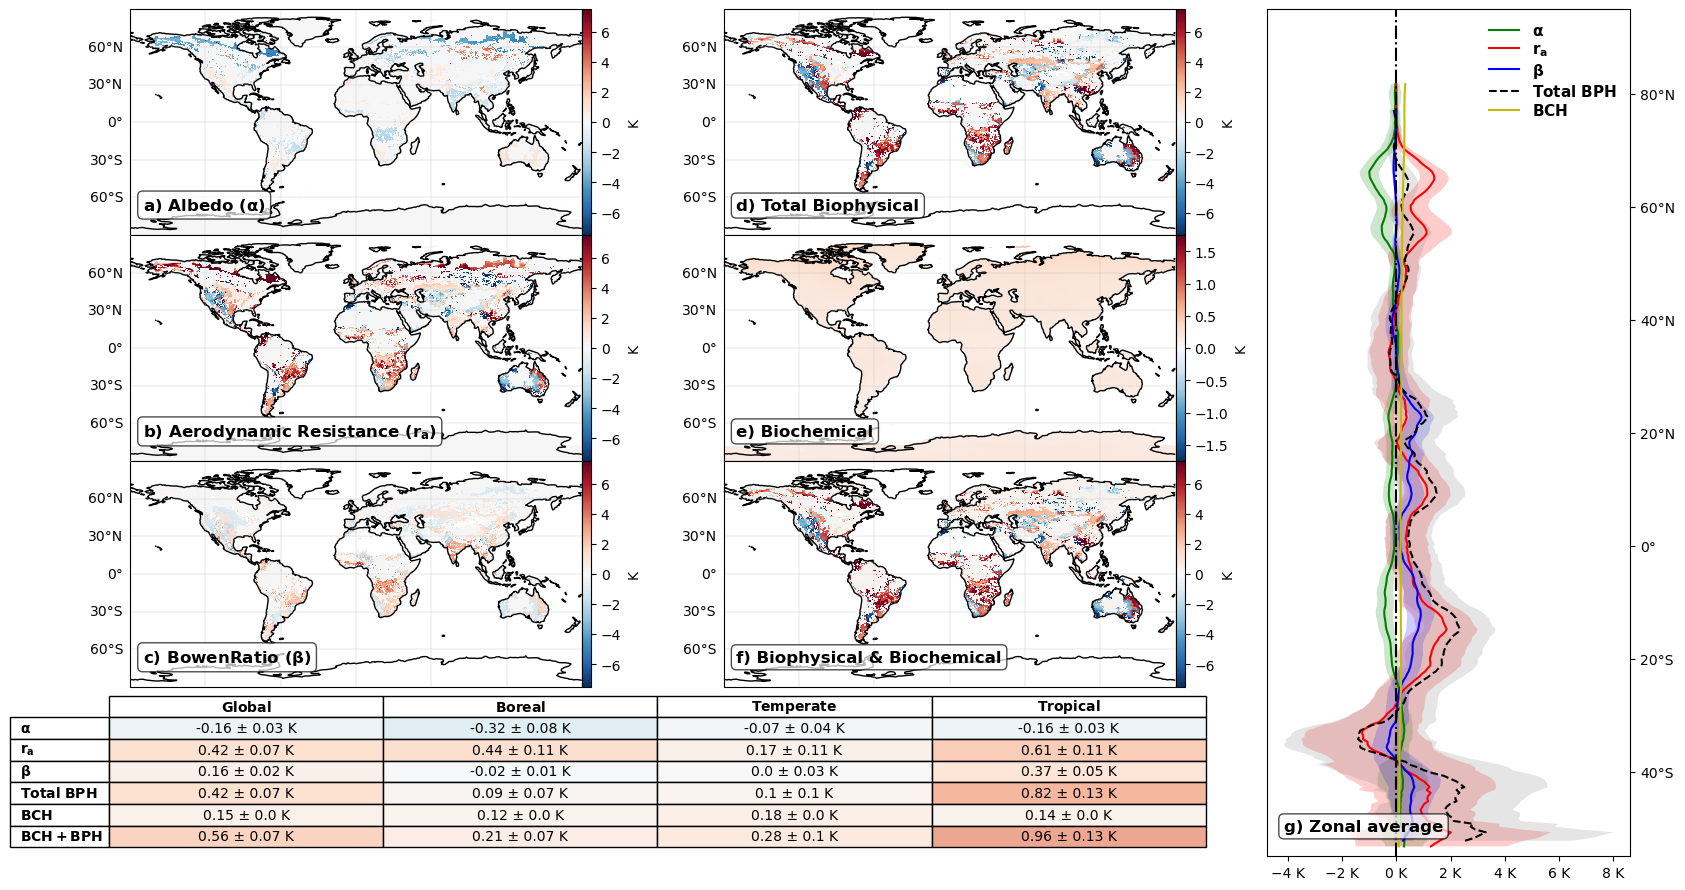

In [49]:
fig = plt.figure(figsize=(20, 11),dpi=100)
G = gridspec.GridSpec(15, 8, hspace=0,wspace=0.2)


#========================================================================
# Design axs
#========================================================================

axes_1 = plt.subplot(G[0:4,0:3],projection=ccrs.PlateCarree())
axes_2 = plt.subplot(G[4:8, 0:3],projection=ccrs.PlateCarree())
axes_3 = plt.subplot(G[8:12, 0:3],projection=ccrs.PlateCarree())
axes_4 = plt.subplot(G[0:4, 3:6],projection=ccrs.PlateCarree())
axes_5 = plt.subplot(G[4:8, 3:6],projection=ccrs.PlateCarree())
axes_6 = plt.subplot(G[8:12,3:6],projection=ccrs.PlateCarree())
axes_7 = plt.subplot(G[:, 6:])
axes_8 = plt.subplot(G[12:, :6])

#========================================================================
# Plot 6 Maps
#========================================================================

alb = alb_contr.plot.pcolormesh(ax=axes_1, vmin=-7.5, vmax=7.5, cmap='RdBu_r',add_colorbar=False,rasterized=True)
ra = ra_contr.plot.pcolormesh(ax=axes_2, vmin=-7.5, vmax=7.5, cmap='RdBu_r',add_colorbar=False,rasterized=True)
beta = beta_contr.plot.pcolormesh(ax=axes_3, vmin=-7.5, vmax=7.5, cmap='RdBu_r',add_colorbar=False,rasterized=True)
total_bph = bph_tot.plot.pcolormesh(ax=axes_4, vmin=-7.5, vmax=7.5, cmap='RdBu_r',add_colorbar=False,rasterized=True)
total_bch = carbon_contr.plot.pcolormesh(ax=axes_5, vmin=-1.75, vmax=1.75, cmap='RdBu_r',add_colorbar=False,rasterized=True)
bchandbph = (bph_tot+carbon_contr).plot.pcolormesh(ax=axes_6, vmin=-7.5, vmax=7.5, cmap='RdBu_r',add_colorbar=False,rasterized=True)

#========================================================================
# Tidy them
#========================================================================

vari = [alb,ra,beta,total_bph,total_bch,bchandbph]
for ax,var in zip(fig.axes[:-2],vari):
    make_it_nice(ax,var)

#========================================================================
# Zonal ax
#========================================================================
    
y = alb_contr.latitude
linestyles = ['g-','r-','b-','k--','y-']
fcolors = ['green','red','blue','grey','yellow']
labels = [r'$\mathbf{\alpha}$',r'$\mathbf{r_{a}}$',r'$\mathbf{\beta}$',r'$\mathbf{Total \ BPH}$',r'$\mathbf{BCH}$']

for i,var in enumerate([alb_contr,ra_contr,beta_contr,bph_tot,carbon_contr]):
    line,err = get_zonal(var)
    axes_7.plot(line,y,linestyles[i],label=labels[i])
    axes_7.fill_betweenx(y,line+err,line-err,alpha=.2,facecolors=fcolors[i])
    
axes_7.axvline(color='k', linestyle='-.')
axes_7.set_ylim(-55,95)
#axes_7.set_xlim(-3,3)
axes_7.yaxis.tick_right()
axes_7.yaxis.set_label_position("right")

xformatter = ticker.EngFormatter(unit='K')
yformatter = LATITUDE_FORMATTER
axes_7.xaxis.set_major_formatter(xformatter)
axes_7.yaxis.set_major_formatter(yformatter)

#axes_7.legend(loc='upper left',framealpha=0,labelspacing=.2,prop={'size':11})
axes_7.legend(loc='upper right',framealpha=0,labelspacing=.2,prop={'size':11})

bbox=dict(facecolor='white', edgecolor='black', boxstyle='round',alpha=.7)    
    
    
    
#========================================================================
# Table ax
#========================================================================
columns = (r'$\mathbf{Global}$',r'$\mathbf{Boreal}$',r'$\mathbf{Temperate}$',r'$\mathbf{Tropical}$',)
rows = [r'$\mathbf{\alpha}$',r'$\mathbf{r_{a}}$',r'$\mathbf{\beta}$',
        r'$\mathbf{Total \ BPH}$',r'$\mathbf{BCH}$',r'$\mathbf{BCH+BPH}$']

# Get some pastel shades for the colors
#colors = plt.cm.RdBu(np.linspace(0.3, 0.5, len(rows)))

# Add a table at the bottom of the axes
table = axes_8.table(cellText=data,
                     rowLabels=rows,colLabels=columns,
                     rowColours=None,colColours=None,
                     cellColours=cellcolor,
                     cellLoc='center',loc='center')

axes_8.get_xaxis().set_visible(False)
axes_8.get_yaxis().set_visible(False)
axes_8.axis('off')
#plt.box(on=None)
table.scale(.95, 1.3)

#========================================================================
# Annotate
#========================================================================
axes_1.text(-170, -70, 'a) Albedo ' + r'($\mathbf{\alpha)}$',size=12, weight='bold',bbox=bbox)
axes_2.text(-170, -70, 'b) Aerodynamic Resistance '+ r'($\mathbf{r_{a})}$',size=12, weight='bold',bbox=bbox)
axes_3.text(-170, -70, 'c) BowenRatio '+ r'($\mathbf{\beta)}$',size=12, weight='bold',bbox=bbox)
axes_4.text(-170, -70, 'd) Total Biophysical',size=12, weight='bold',bbox=bbox)
axes_5.text(-170, -70, 'e) Biochemical',size=12, weight='bold',bbox=bbox)
axes_6.text(-170, -70, 'f) Biophysical & Biochemical',size=12, weight='bold',bbox=bbox)
axes_7.text(0.045, 0.03, 'g) Zonal average',size=12, weight='bold',bbox=bbox,transform=axes_7.transAxes);



#========================================================================
# Save
#========================================================================

if scenario == 0:
    plt.savefig('fig1.pdf',bbox_inches='tight')
if scenario == 1:
    plt.savefig('fig2.pdf',bbox_inches='tight')
if scenario == 2:
    plt.savefig('fig3.pdf',bbox_inches='tight')